In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
import numpy as np
from glob import glob
from os.path import join 
import os, sys
from scikits.bootstrap import ci
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection

sys.path.insert(1, "../MLpipelines/")
from plotResults import *

sns.set(style="whitegrid", context='paper', color_codes=False)

### Plot results

In [3]:
# dfi = pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-64net/run.csv"))[-1])
# temp = dfi.model
# dfi.model = dfi.m__name
# dfi.m__name = temp
# dfi.i = 'X'
# dfi.o = 'Binge'
# dfi['i_is_conf'] = False
# dfi['o_is_conf'] = False
# dfi['io'] = dfi.apply(lambda r: f"{r.i}-{r.o}", axis=1)

# dfi.to_csv("results/fullbrain-fu3-z2-bingel3u6-n/20210907-1206-64net/run.csv", index=False)
# dfi.head()

#### Best accuracy

In [4]:
df = pd.concat([
#         pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-64net/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn32/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-loss/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-b16/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-b20/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-drop/run.csv"))[-1]),
        pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-pt2/run.csv"))[-1]),
])

assert len(df)
df["model"] = df.apply(lambda row: 
        f"{row['model'].split('debug')[0]}\
ls:{'weight' in row['m__criterion']}), \
b:{row['m__batch_size']}, \
pt:{(row['m__weights_pretrained']!='None')}",
                       axis=1) #pt:{(row['m__weights_pretrained']!='None')}, 
df['val_score'] = df.apply(lambda row: 
        row['val_classif_accuracy'] if not pd.isna(row['val_classif_accuracy'])  else row['val_binary_balanced_accuracy'],axis=1)
# df['val_score']

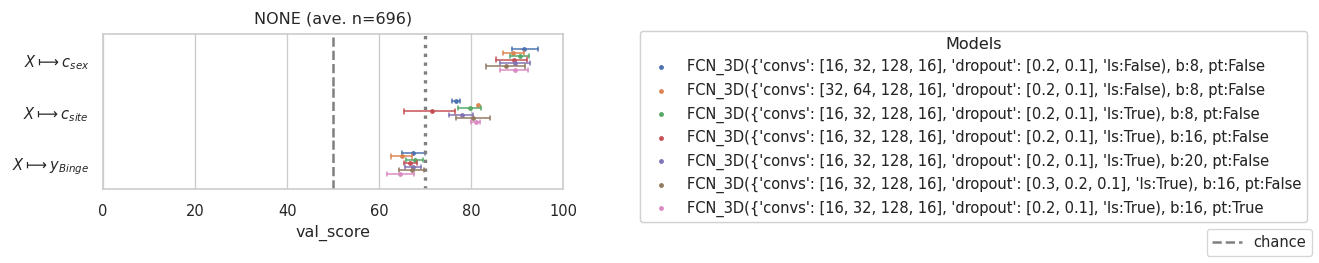

In [5]:
f = plot_result(df, no_confs=False, x='val_score')
f.gca().axvline(70, lw=2, ls=':', c='grey', label='svm-baseline')
plt.show()

In [29]:
df["model_vars"] = df.apply(lambda row: 
        f"{row['model']}(pt:{(row['m__weights_pretrained']!='None')})"
                         ,axis=1)
df["model_vars"].value_counts()

SixtyFourNet(pt:True)    5
Name: model_vars, dtype: int64

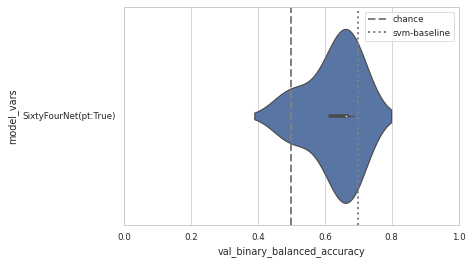

In [31]:
best_metric = 'val_binary_balanced_accuracy'
g = sns.violinplot(x=best_metric, data=df, y="model_vars")
g.set_xlim([0.,1])
g.axvline(0.5, lw=2, ls='--', c='gray', label='chance')
g.axvline(0.7, lw=2, ls=':', c='grey', label='svm-baseline')
g.legend()
plt.show()

####  training curves

In [128]:
def plot_training_curves(df):
    f, axes = plt.subplots(1,2, figsize=(10,4))
    metrics = ['loss', 'binary_balanced_accuracy']

    for ax, metric  in zip(axes.ravel(), metrics):
        
        for i, row in df[df.o == 'Binge'].iterrows():
            ax.plot(eval(row['train_curve_'+metric]), color='b')
            ax.plot(eval(row['val_curve_'+metric]), color='r')
        ax.set_title(metric.upper())
        ax.set_ylim([0.,1.])
        ax.legend(["Train", "Val"])
        ax.set_xlabel('epochs')
    return f, axes

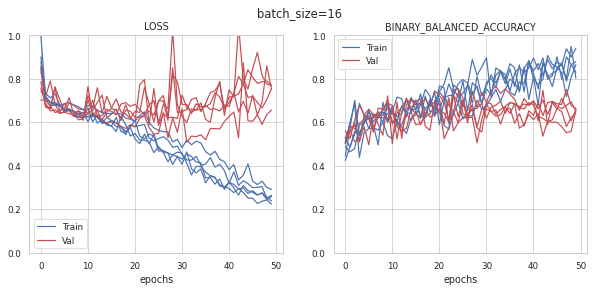

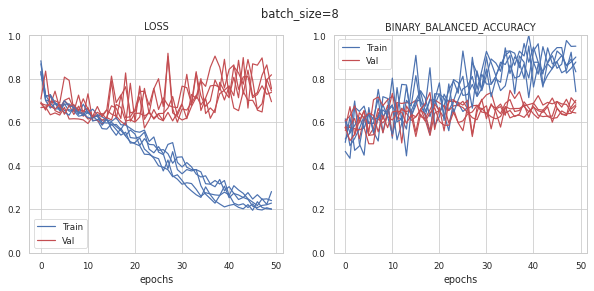

In [135]:
df = pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-b16/run.csv"))[-1])
f, axes = plot_training_curves(df)
f.suptitle("batch_size=16")
plt.show()
df = pd.read_csv(sorted(glob(f"results/fullbrain-fu3-*/*-fcn16-loss/run.csv"))[-1])
f, axes = plot_training_curves(df)
f.suptitle("batch_size=8")
plt.show()

####  confounds

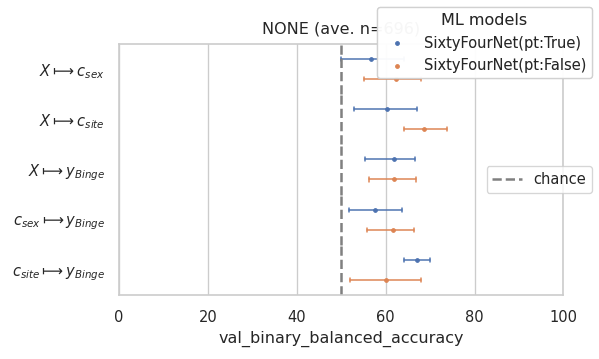

In [ ]:
plot_result(df, x="specificity", no_confs=False, input_type='sMRI (22yrs)')
plt.show()
plot_result(df, x="sensitivity", no_confs=False, input_type='sMRI (22yrs)')
plt.show()

### Utils

#### Runtime

In [ ]:
df = pd.read_csv(glob("results/*AUDIT*AUDIT*BINGE*BINGE*/*/run.csv")[-1])
df["runtime"]= df["runtime"]/60
sns.barplot(x="model", y="runtime", hue="io", data=df)
plt.ylabel("in minutes")
plt.show()

#### Combine result folders

In [38]:
# # Only merge unmerged csvs only
f = "results/fullbrain-fu3-z2-bingel3u6-n/20210916-1151"
csvs = glob(f+"/run*.csv")
if len(csvs)>1 and not os.path.exists(f+"/run.csv"): 
    df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)      
    # delete the old temp parallel csv files
    os.system(f"rm {f}/run*.csv")  
    df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # drop unnamed columns            
    df = df.sort_values(['conf_ctrl_tech','i','o','run_id']) # sort
    df.to_csv(f+"/run.csv", index=False)  
    print("merged temp-csvs that were present in folder", f)

merged temp-csvs that were present in folder results/fullbrain-fu3-z2-bingel3u6-n/20210916-1151


In [3]:
# join multiple results folders into one
join_results = sorted(glob("results/fullbrain-fu3-*/*"))
print("Combining results in folders:")
for f in join_results: print(f)
save_to = join_results[-1]
print(f"to one folder: \n{save_to}")

Combining results in folders:
results/fullbrain-fu3-z2-bingel3u6-n/20210819-0922
results/fullbrain-fu3-z2-bingel3u6-n/20210820-1529
results/fullbrain-fu3-z2-bingel3u6-n/20210823-1057
to one folder: 
results/fullbrain-fu3-z2-bingel3u6-n/20210823-1057


In [ ]:
from shutil import move
# combine the csv files and save in 'save_to' dir
# if there are unmerged run().csv files then merge them first
for f in join_results:
    csvs = glob(f+"/run*.csv")
    if len(csvs)>1 and not os.path.exists(f+"/run.csv"): 
        df = pd.concat([pd.read_csv(csv) for csv in csvs], ignore_index=True)      
        # delete the old temp parallel csv files
        os.system(f"rm {f}/run*.csv")  
        df = df.loc[:, ~df.columns.str.contains('^Unnamed')] # drop unnamed columns            
        df = df.sort_values(['conf_ctrl_tech','i','o','run_id']) # sort
        df.to_csv(f+"/run.csv", index=False)  
        print("merged temp-csvs that were present in folder", f)
        
pd.concat([pd.read_csv(f+"/run.csv") for f in join_results])
runs = pd.concat([pd.read_csv(f+"/run.csv") for f in join_results])
# drop any duplicates
# df = df.loc[:,~df.columns.duplicated()]
runs.to_csv(join(save_to,'run.csv'), index=False)
print(f"merged run.csv files from {[f for f in join_results if f!=save_to]} to single run.csv in {save_to}")
runs.info()

In [ ]:
# move the rest of the files to 'save_to' dir but replace the run_ids
for folder in join_results[:-1]:
    n_run_ids = len(glob(join(save_to,'*.log')))
    for path in glob(folder+"/*.*"):
        file = os.path.basename(path)
        run_id = (file.split('.')[0].split('_')[0].replace('run', ''))
        try: 
            run_id = int(run_id)
        except:
            if 'run.csv' not in file:
                print(f"[WARN] could not figure out the run_id for {path}")
            break
        
        new_run_id = n_run_ids+run_id
        new_path = join(save_to, file.replace(str(run_id), str(new_run_id),  1))
        print('Saving file \n{} as \n{} \nby replacing run-id from {} to {}'.format(path, new_path, run_id, new_run_id))
        print(move(path, new_path))

In [ ]:
for folder in join_results[:-1]:
    # delete the old folder
    if len(glob(folder+"/*.*"))==1 and os.listdir(folder)[0]=='run.csv':
        os.system(f"rm -rf {folder}")
    else:
        print(f"[WARN] could not move all files in {folder}. exiting.. ")
        break